In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()
import datetime as dt

In [2]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) ## change float at the macro level

In [3]:
def Binary_BS (spot, strike, T, sigma, rf = 0, Q = 1):
    
    """""""""
    Adjusted Black Scholes model for pricing European binary options where the payoff equals 1.
    
    
    rf - risk free rate;
    spot - current spot price of the target asset;
    strike - option strike price;
    T - time, measured in years. For instance 1 month would be 1/12;
    sigma - expected annual volatility. For instance, 100% annual volatility would mean sigma in our model equals 1;
    Q - binary option payoff
    
    binary_call = Q * exp(-rfT)*N(d2)
    binary_put = Q*exp(-rfT)*N(-d2)

    """""""""
    
    d1 = (np.log(spot/strike) + T * (rf + (sigma**2)/2)) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    neg_d1 = -d1
    neg_d2 = -d2
    
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    N_neg_d1 = norm.cdf(neg_d1)
    N_neg_d2 = norm.cdf(neg_d2)
    
    exp1 = np.exp(-rf*T)    
    
    call_price = Q * exp1 * N_d2
    put_price = Q * exp1 * N_neg_d2 
    
    data = pd.DataFrame(data = [call_price, put_price], columns = ['Price'], index = ['Call', 'Put'])

    return data

In [4]:
def Binary_Binomial (spot, strike, T, sigma, N, rf = 0, Q = 1, div_yield = 0):
    
    """""""""
    Using Binomial model to price European binary options where the payoff equals 1. 
    
    rf - risk free rate;
    spot - current spot price of the target asset;
    strike - option strike price;
    T - time, measured in years. For instance 1 month would be 1/12;
    sigma - expected annual volatility. For instance, 100% annual volatility would mean sigma in our model equals 1.
    N - number of binomial steps
    Q - binary option payoff;
    
    The factor by which the price raises: u = exp (std * sqrt(delta t));
    The factor by which the price falls: d = 1/u;
    Probability of price going up: pu = [exp(delta t * (rf - k)) - d] / [u - d];
    Probability of pirce going down: pd = 1 - pu;

    Stock price at the end of the period according to binomial model is:
    S0 * u ^ (# of steps up) * d ^ (# of steps down)
    """""""""
    
    delta_T = T/N
    
    NR = np.exp((rf - div_yield) * delta_T)
    GR = np.exp(rf*delta_T)
    
    u = np.exp(sigma * np.sqrt(delta_T))
    d = 1/u

    p_up = (NR - d) / (u - d) 
    p_down = 1 - p_up

    discount = np.exp(-rf*T)    
    
    df = pd.DataFrame(data = np.arange(0, N+1), columns = ["Number of down steps"])
    df['S(t)'] = spot * u ** (N - df['Number of down steps']) * d ** (df["Number of down steps"])

    call_price = []
    put_price = []
    for i in range(len(df)):
        if (float(df['S(t)'].iloc[i:i+1] - strike))>0: # if spot price larger than strike price call price = payoff; put price = 0
            call_price.append(Q)
            put_price.append(0) 
        else: # if strike price larger than spot price call price = 0; put price = payoff
            call_price.append(0)
            put_price.append(Q)

    df["Call (t)"] = call_price
    df['Put (t)'] =  put_price

    df["Probability for the nod"] = p_up ** (N - df["Number of down steps"]) * p_down ** (df["Number of down steps"])

    df["Number"] = N

    df["Number Chosen"] = df["Number"] - df["Number of down steps"]

    paths = []
    for i in range(len(df)):
        paths.append ((np.math.factorial(float(df["Number"].iloc[i:i+1]))) / (np.math.factorial(float(df["Number Chosen"].iloc[i:i+1])) * np.math.factorial(float(df["Number"].iloc[i:i+1]) - float(df["Number Chosen"].iloc[i:i+1]))))

    df["Number of paths"] = paths

    df['Pr of S{t}'] = df["Probability for the nod"] * df["Number of paths"]

    df["Call (t) * Pr"] = df["Call (t)"] * df["Pr of S{t}"]
    df["Put (t) * Pr"] = df["Put (t)"] * df["Pr of S{t}"]
    
    data = pd.DataFrame(data = [df["Call (t) * Pr"].sum() * discount, df["Put (t) * Pr"].sum() * discount], columns = ['Price'], index = ['Call', 'Put'])
    
    return data, df

In [65]:
rf, spot, strike, T, sigma, Q = 0, 5000, 5200, 3/365, 0.8, 1

input_frame = pd.DataFrame(data = [rf, spot, strike, T, sigma, Q], columns=['Input'], 
                   index=['Risk-free rate', 'Spot', 'Strike', 'T', 'Volatility', 'Payoff'])
display(input_frame)

,Input
Risk-free rate,0.0000
Spot,5000.0000
Strike,5200.0000
T,0.0082
Volatility,0.8000
Payoff,1.0000


In [64]:
Binary_BS(spot, strike, T, sigma)

,Price
Call,0.1873
Put,0.8127


In [7]:
Binary_Binomial(spot, strike, T, sigma, N = 500)[0]

,Price
Call,0.0508
Put,0.9492


In [10]:
sigmas = np.arange(0.5, 2, 0.05)

bs_ = []
binomial = []
for i in range(len(sigmas)):
    bs_.append(Binary_BS(spot, strike, T, sigmas[i])['Price']['Call'])
    binomial.append(Binary_Binomial(spot, strike, T, sigmas[i], N = 500)[0]['Price']['Call'])
    
df1 = pd.DataFrame(data = [sigmas, bs_, binomial], index = ['Volatility', 'BS', 'Binomial']).T
df1 = df1.set_index('Volatility')

In [11]:
# The more we increase N in the binomial model the closer the price is to the BS model

<AxesSubplot:xlabel='Volatility'>

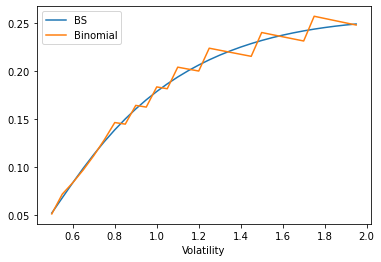

In [12]:
df1.plot()

In [13]:
maturity = np.arange(1, 360, 5) / 360

bs_ = []
binomial = []
for i in range(len(maturity)):
    bs_.append(Binary_BS(spot, strike, maturity[i], sigma)['Price']['Call'])
    binomial.append(Binary_Binomial(spot, strike, maturity[i], sigma, N = 500)[0]['Price']['Call'])
    
df2 = pd.DataFrame(data = [maturity, bs_, binomial], index = ['Maturity', 'BS', 'Binomial']).T
df2 = df2.set_index('Maturity')

<AxesSubplot:xlabel='Maturity'>

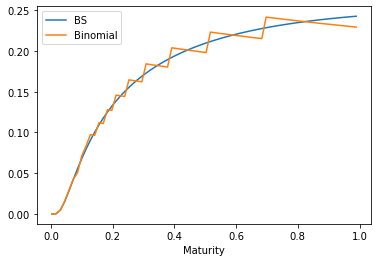

In [14]:
df2.plot()

In [15]:
spot = np.arange(50, 200, 5)

bs_ = []
binomial = []
for i in range(len(spot)):
    bs_.append(Binary_BS(spot[i], strike, T, sigma)['Price']['Call'])
    binomial.append(Binary_Binomial(spot[i], strike, T, sigma, N = 500)[0]['Price']['Call'])
    
df3 = pd.DataFrame(data = [spot, bs_, binomial], index = ['Spot', 'BS', 'Binomial']).T
df3 = df3.set_index('Spot')

<AxesSubplot:xlabel='Spot'>

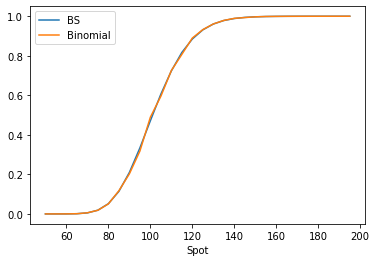

In [16]:
df3.plot()

# Pricing ETH Binary Options

In [17]:
def get_data_for_the_past_x_days(coin_name, day_num, currency = 'usd', data_type = "prices"):
    """""""""
    get_data_for_the_past_x_days(coin_name='bitcoin', day_num=120)
    data_type could be market_caps or total volumes 
    day_num should be higher than 90 to get daily data, if lower can only get hourly data
    """""""""
    data = cg.get_coin_market_chart_by_id(id = coin_name, vs_currency = currency, days = day_num)
    data = data[data_type]
    date = []
    price = []
    for i in range(len(data)):
        date.append(dt.datetime.fromtimestamp((data[i][0])/1000))
        price.append(data[i][1])
    
    df = pd.DataFrame(data = price, index = date, columns=[coin_name])
    
    return df

## Below volatility annualization is only for hourly data. Don't use if working with daily data!!! 

In [116]:
def sigma_spot(token, days):
    
    if days>90:
        return 'Error. Please input less than 90 days'
    
    else:
        data = get_data_for_the_past_x_days(token, days)
        returns = (np.log(data)-np.log(data.shift(1)))[1:]
        sigma = (np.std(returns) * np.sqrt(24*365))[0]
        
    recent_price = data[-1:][token][0]
    
    return sigma, recent_price

In [117]:
data = sigma_spot('ethereum', 90)

In [120]:
sigma = data[0]
spot = data[1]

In [121]:
strike = 5000

In [122]:
input_frame = pd.DataFrame(data = [rf, spot, strike, T, sigma, Q], columns=['Input'], 
                   index=['Risk-free rate', 'Spot', 'Strike', 'T', 'Volatility', 'Payoff'])
display(input_frame)

,Input
Risk-free rate,0.0000
Spot,4715.9527
Strike,5000.0000
T,0.0082
Volatility,0.8141
Payoff,1.0000


In [123]:
Binary_BS(spot, strike, T, sigma)

,Price
Call,0.2035
Put,0.7965


In [124]:
Binary_Binomial(spot, strike, T, sigma, N = 500)[0]

,Price
Call,0.2127
Put,0.7873
